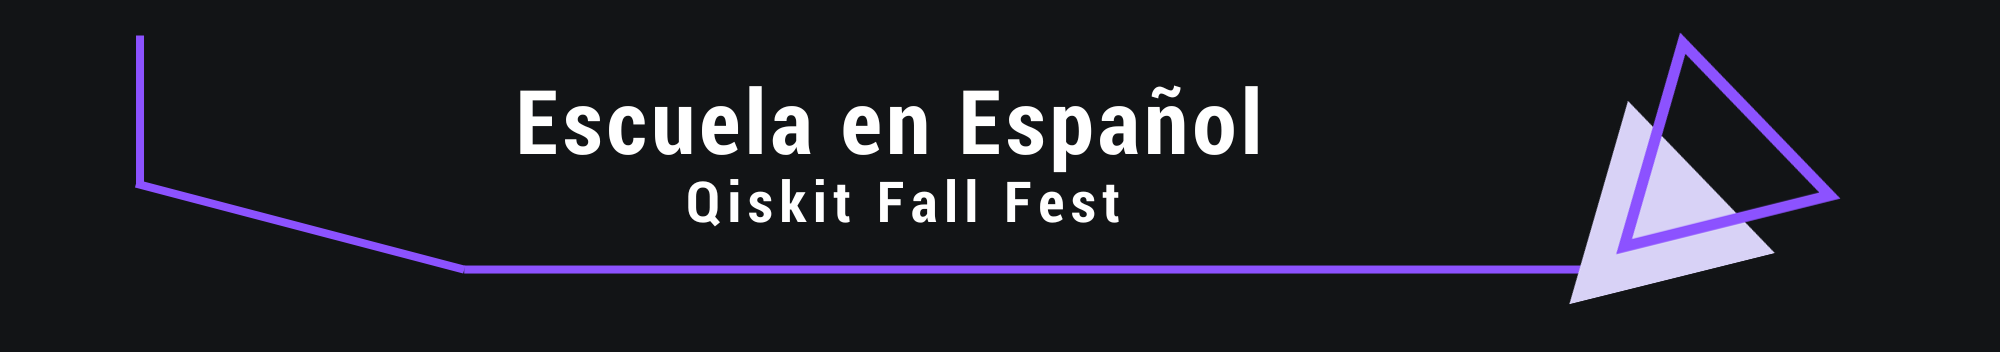

# Ejercicio 5: Química Cuántica

## Importación de bibliotecas

Primero, comencemos importando algunas bibliotecas. Usaremos uno de los módulos de aplicación de Qiskit: Qiskit Nature aquí para cargar controladores de química y las funciones necesarias para ayudarnos a formular nuestro problema y resolver la molécula que tenemos a la mano.

In [1]:
# Import necessary libraries and packages
import math
import matplotlib.pyplot as plt
import numpy as np

import warnings
warnings.filterwarnings('ignore')

from qiskit import Aer, IBMQ, QuantumCircuit
from qiskit.primitives import Estimator
from qiskit.providers.aer import StatevectorSimulator
from qiskit.utils import QuantumInstance

from qiskit.tools.jupyter import *
from qiskit.visualization import *

# Import Qiskit libraries for VQE
from qiskit.algorithms import MinimumEigensolverResult, VQE
from qiskit.algorithms.optimizers import SLSQP, SPSA

# Import Qiskit Nature libraries
from qiskit_nature.algorithms import GroundStateEigensolver, VQEUCCFactory
from qiskit_nature.algorithms.ground_state_solvers.minimum_eigensolver_factories import NumPyMinimumEigensolverFactory
from qiskit_nature.circuit.library import UCC, UCCSD
from qiskit_nature.drivers import Molecule
from qiskit_nature.drivers.second_quantization import ElectronicStructureDriverType, ElectronicStructureMoleculeDriver
from qiskit_nature.converters.second_quantization import QubitConverter
from qiskit_nature.mappers.second_quantization import BravyiKitaevMapper, JordanWignerMapper, ParityMapper
from qiskit_nature.problems.second_quantization.electronic import ElectronicStructureProblem
from qiskit_nature.transformers.second_quantization.electronic import ActiveSpaceTransformer

# Prototype-zne
!pip install prototype-zne --quiet

from qiskit_nature.settings import settings

settings.dict_aux_operators = True


[notice] A new release of pip available: 23.1.1 -> 23.3.1
[notice] To update, run: pip install --upgrade pip


## Construcción de nuestro Modelo desde cero

### 1. Definir la geometría de la molécula y obtener las propiedades moleculares

El primer paso es definir nuestras moléculas especificando sus coordenadas atómicas, espín total (multiplicidad) e información de carga. Para ello, primero declararemos la estructura molecular en coordenadas cartesianas y estableceremos un controlador químico según su carga y multiplicidad.

La geometría molecular se puede encontrar buscando en artículos de investigación **[[9]](https://pubchem.ncbi.nlm.nih.gov/) [[10]](https://webbook.nist.gov/chemistry/form-ser/)**. En este ejercicio, usaremos las propiedades que se originan de esta fuente **[[11]](https://aip.scitation.org/doi/abs/10.1063/1.433585)** con una aproximación de la estructura del triángulo equilátero como en la imagen de abajo.

La multiplicidad de los niveles de energía se define como $2S + 1$, donde $S$ es el espín total de la molécula. $H_3^+$ tiene dos electrones, y al obedecer el **[principio de Aufbau](https://en.wikipedia.org/wiki/Aufbau_principle)** y el **[principio de Pauli](https://en.wikipedia.org/wiki/Pauli_exclusion_principle)**, el espín total de dos electrones se cancela debido a su configuración  ($\uparrow + \downarrow $), lo que lleva a una multiplicidad de 1.

Con esta información, terminemos la siguiente parte para incluir la estructura molecular apropiada.

<a id="Paso 1"></a>

<div class="alert alert-block alert-success">
<b>Paso 1:</b> 
    
Completa la siguiente declaración de molécula de acuerdo con la estructura de $H_3^+$. Según la referencia, la distancia atómica entre $H$ es **0.91396** $\text{Å}$ y es una estructura de triángulo equilátero. Nuestra molécula objetivo contiene **dos electrones** con **carga +1**. Para calificar tu respuesta, <b>no</b> cambies la base.</div>
</div>

<div class="alert alert-block alert-info">
    <b> Nota: Espín y Multiplicidad de moléculas </b>

Necesitamos especificar qué estado electrónico calcular. En los cálculos de química cuántica, $S$ corresponde al espín de los electrones no pareados. El espín de los electrones es $\frac{1}{2}$, por lo que el espín total se puede describir de la siguiente manera,<br>
$S = \frac{1}{2} \times \mathrm{número\ de\ electrones\ no\ pareados}$. <br>
La multiplicidad de espín es $2S + 1$, que es el "$\mathrm{número\ de\ electrones\ no\ pareados}+1$".
    
</div>

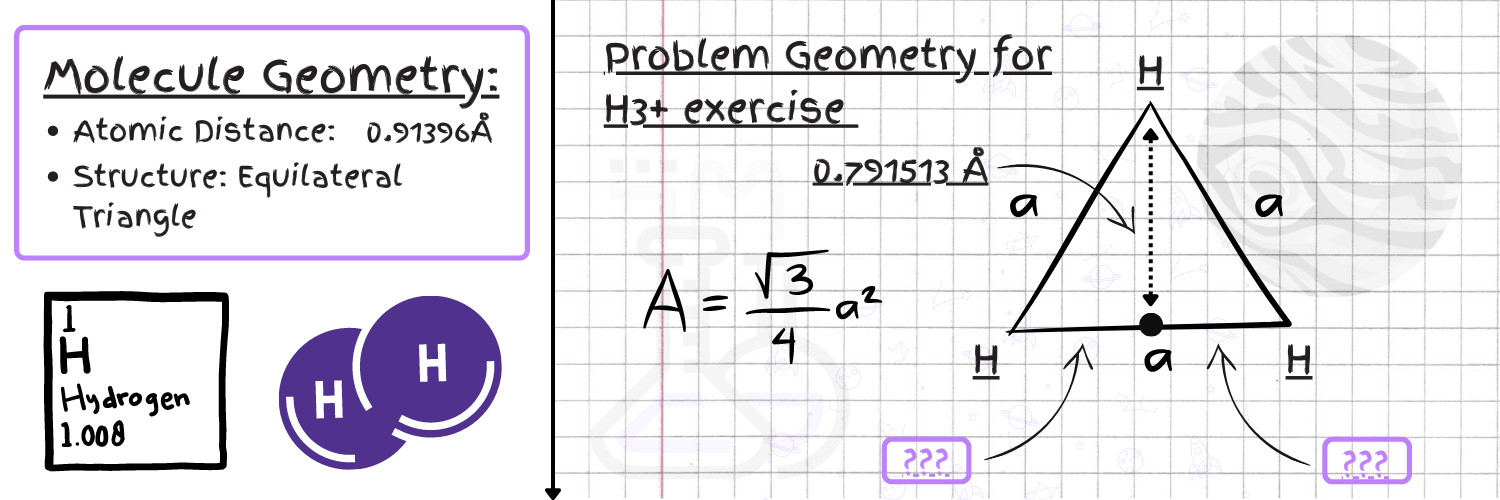

In [2]:
#### Fill in the values below and complete the function to define the Molecule ####
value = # ----------- Enter your code here
# Coordinates are given in Angstrom
value = 0.45698
hydrogen_t = [["H", [value, 0.0, 0.0]], 
              ["H", [-value, 0.0, 0.0]], 
              ["H", [0.0, 0.791513, 0.0]]]
                  
h3p = Molecule( # Fill up the function below
    geometry=hydrogen_t , # ----------- Enter your code here
    multiplicity=1, # ----------- Enter your code here
    charge=1, # ----------- Enter your code here
)

driver = ElectronicStructureMoleculeDriver(h3p, basis="ccpvdz", driver_type=ElectronicStructureDriverType.PYSCF) 

properties = driver.run()


El controlador Qiskit Nature nos brinda algunas propiedades de la molécula (ver también: **[El Framework Propiedades](https://qiskit.org/documentation/nature/tutorials/08_property_framework.html)**), ¡veamos algunas ahora!

*Pegunta 1:*

In [3]:
num_alpha_electrons = properties.get_property('ParticleNumber').num_alpha
num_beta_electrons = properties.get_property('ParticleNumber').num_beta
num_spin_orbitals = int(properties.get_property('ParticleNumber').num_spin_orbitals)

nuclear_rep_energy = properties.get_property('ElectronicEnergy').nuclear_repulsion_energy
print("number of alpha electrons: " , num_alpha_electrons)
print("number of beta electrons: " , num_beta_electrons)
print("number of spin orbitals: " , num_spin_orbitals)
print("nuclear repulsion energy: " , nuclear_rep_energy)

number of alpha electrons:  1
number of beta electrons:  1
number of spin orbitals:  30
nuclear repulsion energy:  1.736981060004552


### 2. Problema de Estructura Electrónica y Transformador de Espacio Activo


El siguiente paso es seleccionar nuestro espacio activo que describirá qué orbitales moleculares se simularán con VQE y tratará el resto con métodos clásicos. Cuantos más orbitales incluyamos en nuestro espacio activo, más costoso computacionalmente será nuestro circuito cuántico. Como tal, el objetivo es construir el espacio activo más preciso con la menor cantidad de orbitales posible.

En Qiskit Nature, usamos `ActiveSpaceTransformer` para especificar cuántos electrones y orbitales moleculares nos gustaría tener en nuestro espacio activo, así como cuáles de esos orbitales particulares nos gustaría considerar.
Después de eso, puedes crear un `ElectronicStructureProblem` que produzca una lista de operadores fermiónicos antes de asignarlos a qubits (cadenas de Pauli).

<div class="alert alert-block alert-info">
    <b> Nota: Espacio Activo </b>

    
A medida que aumenta el tamaño del problema, el costo computacional (número de qubits (que corresponde al número de orbitales que se utilizan) y la profundidad del circuito (que corresponde al número de excitaciones electrónicas consideradas)) aumenta rápidamente. El enfoque de espacio activo es un enfoque bien conocido para reducir el costo computacional. En muchos problemas de química, los orbitales ocupados con electrones de alta energía y los orbitales desocupados con baja energía juegan un papel importante. Entonces, en lugar de tratar todos los orbitales y electrones con la misma precisión, tratar esos electrones y orbitales importantes con alta precisión es una buena aproximación en general. Por lo tanto, podemos seleccionar los orbitales y electrones importantes como nuestro espacio activo y resolver el problema a bajo costo mientras mantenemos la precisión del cálculo.
    
</div>

In [4]:
# Check the occupation of the spin orbitals
PN_property = properties.get_property("ParticleNumber")

# Define the active space around the Fermi level 
# (selected automatically around the HOMO and LUMO, ordered by energy)
transformer = ActiveSpaceTransformer(
    num_electrons=2, # Number of electrons in our active space
    num_molecular_orbitals=3, # Number of orbitals in our active space
)

# Now you can get the reduced electronic structure problem
problem_reduced = ElectronicStructureProblem(driver, transformers=[transformer]) 

# The second quantized Hamiltonian of the reduce problem
second_q_ops_reduced = problem_reduced.second_q_ops()

### 3. Mapeo Fermion-Qubit

Debido a que los electrones son fermiones, los Hamiltonianos describen los sistemas electrónicos que consisten en operadores fermiónicos expresados en la segunda cuantización. Dado que las computadoras cuánticas están formadas por qubits, tenemos que transformar esos Hamiltonianos fermiónicos en operadores de qubits. Existen diferentes tipos de mapeadores para transformar operadores fermiónicos en operadores de qubits. Puedes probar diferentes opciones de mapeo, pero nos mantendremos con `ParityMapper`, donde explotaremos las simetrías del problema y aplicaremos la reducción de dos qubits para reducir el tamaño del problema. Siéntete libre de probar diferentes mapeadores y experimentar si lo deseas, pero para los propósitos de la calificación del desafío, usaremos `ParityMapper`.

In [5]:
# Setup the mapper and qubit converter
mapper_type = 'ParityMapper'

if mapper_type == 'ParityMapper':
    mapper = ParityMapper()
elif mapper_type == 'JordanWignerMapper':
    mapper = JordanWignerMapper()
elif mapper_type == 'BravyiKitaevMapper':
    mapper = BravyiKitaevMapper()


converter = QubitConverter(mapper)

qubit_op = converter.convert(second_q_ops_reduced["ElectronicEnergy"])
print(qubit_op)

-2.370578202319901 * IIIIII
+ 0.3492296180456815 * IIIIIZ
- 1.724684182860363e-08 * IIIIZX
+ 1.724684182860363e-08 * IIIIIX
+ 0.04107515475324193 * IIIIZZ
+ 0.041075085753784275 * IIIZZI
+ 0.34922961804568164 * IIZZII
- 1.724684182882047e-08 * IZXZII
+ 1.724684182882047e-08 * IIXIII
+ 0.041075154753241985 * IZZIII
+ 0.04107508575378423 * ZZIIII
+ 0.09263375051327206 * IIIIZI
+ 0.09263374411183344 * IIIZZZ
+ 0.17034249149501998 * IIZZIZ
+ 0.018925061845449075 * IZXZZX
- 0.018925061845449075 * IIXIZX
- 0.018925061845449075 * IZXZIX
+ 0.018925061845449075 * IIXIIX
+ 0.0189250502774681 * ZXXIXX
+ 0.0189250502774681 * IYYZXX
+ 0.0189250502774681 * ZXXZYY
+ 0.0189250502774681 * IYYIYY
+ 0.11155881235872114 * IZZIIZ
+ 0.006333539322176453 * IZZIZX
- 0.006333539322176453 * IZZIIX
- 0.00633353249528609 * ZXZZXX
+ 0.00633353249528609 * IXIZXX
- 0.00633353249528609 * ZXZIYY
+ 0.00633353249528609 * IXIIYY
+ 0.11155879438930152 * ZZIIIZ
- 0.006333537574596359 * ZZIIZX
+ 0.006333537574596359 * ZZIII

### Aplicar la reducción

Podemos reducir el tamaño del sistema aplicando varios métodos. Aquí, aplicaremos **[reducción de dos qubits](https://qiskit.org/documentation/stubs/qiskit.opflow.converters.TwoQubitReduction.html)**. El convertidor de reducción de dos qubits elimina el qubit central y último en una lista de Paulis que tienen operadores diagonales (Z, I) en esas posiciones. Este es un buen método que se puede usar en problemas de química para reducir los recursos computacionales. En este ejemplo particular, este método se puede usar para reducir dos qubits en paridad y Hamiltonianos fermiónicos mapeados en árbol binario cuando los orbitales de espín se ordenan en dos sectores de espín (orden de espín en bloque), de acuerdo con la cantidad de partículas en el sistema.

In [6]:
# Set the mapper to qubits
parity_mapper = ParityMapper() # This is the example of parity mapping

# Set the qubit converter with two qubit reduction to reduce the computational cost 
parity_converter = QubitConverter(parity_mapper, two_qubit_reduction=True)    

# Compute the Hamitonian in qubit form
qubit_op_parity = parity_converter.convert(second_q_ops_reduced.get('ElectronicEnergy'), num_particles=problem_reduced.num_particles)

print(qubit_op_parity)

-2.3705782023199 * IIII
+ 0.2715275628536626 * IIIZ
- 1.7246841828603622e-08 * IIZX
+ 1.7246841828603622e-08 * IIIX
- 0.05155858935859148 * IIZZ
+ 0.05155866475948776 * IIZI
- 0.27152756285366275 * IZII
+ 1.7246841828820463e-08 * ZXII
+ 1.7246841828820463e-08 * IXII
- 0.05155858935859142 * ZZII
- 0.05155866475948781 * ZIII
- 0.17034249149501993 * IZIZ
- 0.01892506184544907 * ZXZX
- 0.01892506184544907 * IXZX
+ 0.01892506184544907 * ZXIX
+ 0.01892506184544907 * IXIX
+ 0.018925050277468092 * XXXX
- 0.018925050277468092 * YYXX
- 0.018925050277468092 * XXYY
+ 0.018925050277468092 * YYYY
+ 0.1115588123587211 * ZZIZ
+ 0.0063335393221764505 * ZZZX
- 0.0063335393221764505 * ZZIX
+ 0.0063335324952860875 * XZXX
- 0.0063335324952860875 * XIXX
- 0.0063335324952860875 * XZYY
+ 0.0063335324952860875 * XIYY
+ 0.1115587943893015 * ZIIZ
- 0.006333537574596358 * ZIZX
+ 0.006333537574596358 * ZIIX
- 0.1115588123587211 * IZZZ
- 0.0063335393221764505 * ZXZZ
- 0.0063335393221764505 * IXZZ
- 0.00633353249528

### 4. Calcula la Solución Real para el Graficado de Referencia

Antes de comenzar a calcular el estado fundamental utilizando Qiskit Runtime, calculemos una energía de estado fundamental de referencia mediante `GroundStateEigensolver`.

In [7]:
vqe_factory = VQEUCCFactory( # This is an example of UCC"SD" ansatz
    quantum_instance=Aer.get_backend("aer_simulator_statevector"),
    optimizer=SLSQP(),
    ansatz=UCC(excitations='sd')
) 

from qiskit.algorithms import NumPyMinimumEigensolver

numpy_solver = NumPyMinimumEigensolver()

solver = GroundStateEigensolver(parity_converter, vqe_factory)  # Define Numpy
real_solution_t = solver.solve(problem_reduced).total_energies[0]    
print('Reference energy : ', real_solution_t)

Reference energy :  (-1.3014603031257663+0j)


## Construir una Rutina VQE en Estimator

Para encontrar el estado fundamental, uno de los enfoques más populares es el **algoritmo Variational Quantum Eigensolver (VQE, Solucionador Propio Cuántico Variacional)**. El algoritmo VQE funciona mediante el intercambio de información entre una computadora clásica y una cuántica, como se muestra en la siguiente figura.

En los laboratorios anteriores, aprovechamos las funciones prediseñadas en Terra para ejecutar nuestras instancias de VQE. Aquí, intentaremos construir uno desde cero utilizando la primitiva Estimator. También pasaremos un `noise_model` para simular una rutina de simulación ruidosa más adelante en el cuaderno.

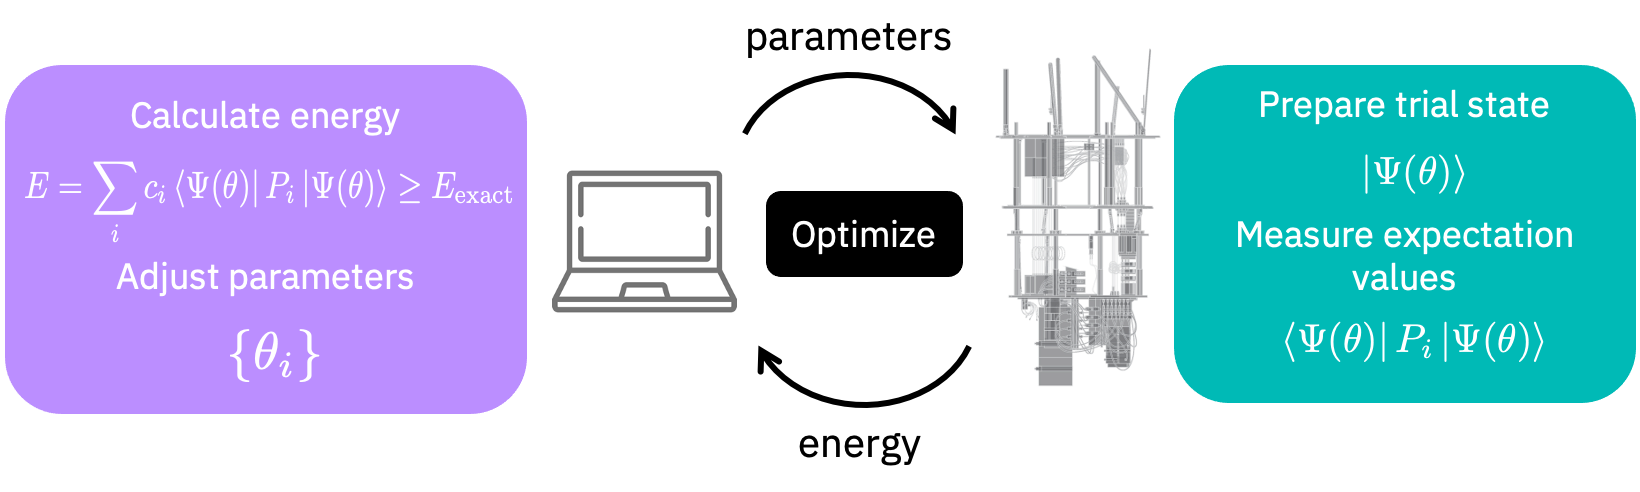

Imágen: [Qiskit Nature Docs: Ground state solver tutorial](https://qiskit.org/documentation/nature/tutorials/03_ground_state_solvers.html)

Desarrollaremos una rutina VQE usando `Estimator` para medir los valores esperados de los estados preparados y usaremos un optimizador clásico para reajustar nuestros parámetros nuevamente para la próxima iteración.

### Construcción de un Solucionador Propio Cuántico Variacional usando Estimator

Para construir una rutina para VQE usando el estimator, veamos nuestra imagen anterior y aprovechemos la misma intuición.

Para nuestro modelo variacional o `ansatz`, que servirá como nuestro circuito modelo para la evaluación y optimización de parámetros, como se muestra en la imagen del tutorial de Qiskit Nature docs de arriba, usaremos un tipo de ansatz específico de química `UCCSD` para nuestro problema.

Como se menciona en este **[tutorial](https://qiskit.org/documentation/nature/tutorials/03_ground_state_solvers.html)** de Qiskit Nature: el ansatz de Clúster Unitario Acoplado (Unitary Coupled Cluster) **[`UCC`](https://qiskit.org/documentation/nature/stubs/qiskit_nature.circuit.library.UCC.html)** (ver **[[12]](https://arxiv.org/abs/1805.04340)** como ejemplo) es un estándar de química ampliamente utilizado en todo el mundo. Aquí especificaremos estados de excitación simple y doble. Sin embargo, se puede seleccionar el tipo de excitación (`'s'`,`'d'`,`'sd'`), así como otros parámetros.

In [8]:
# Define our 'ansatz' for the problem
ansatz = UCC(
    qubit_converter=parity_converter,
    num_particles=problem_reduced.num_particles, 
    num_spin_orbitals=problem_reduced.num_spin_orbitals,
    excitations='sd'
)

A continuación, definiremos cómo estableceremos nuestra rutina con el `Estimator`. Recuerda, el `Estimator` devolverá los valores esperados estimados de los circuitos cuánticos y los observables que se le pasaron. El **circuito** a pasar aquí será nuestro `ansatz`, los **observables** serán el Hamiltoniano `qubit_op_parity` que acabamos de crear y los **parameter_values** serán los valores procesados por el optimizador clásico pasado aquí como `x`. Para nuestro ejemplo, usaremos el optimizador de aproximación estocástica de perturbaciones simultáneas (Simultaneous perturbation stochastic approximation, `SPSA`) para nuestra rutina.

Esto se hará iterativamente y aquí definiremos una rutina como se muestra en la siguiente imagen:

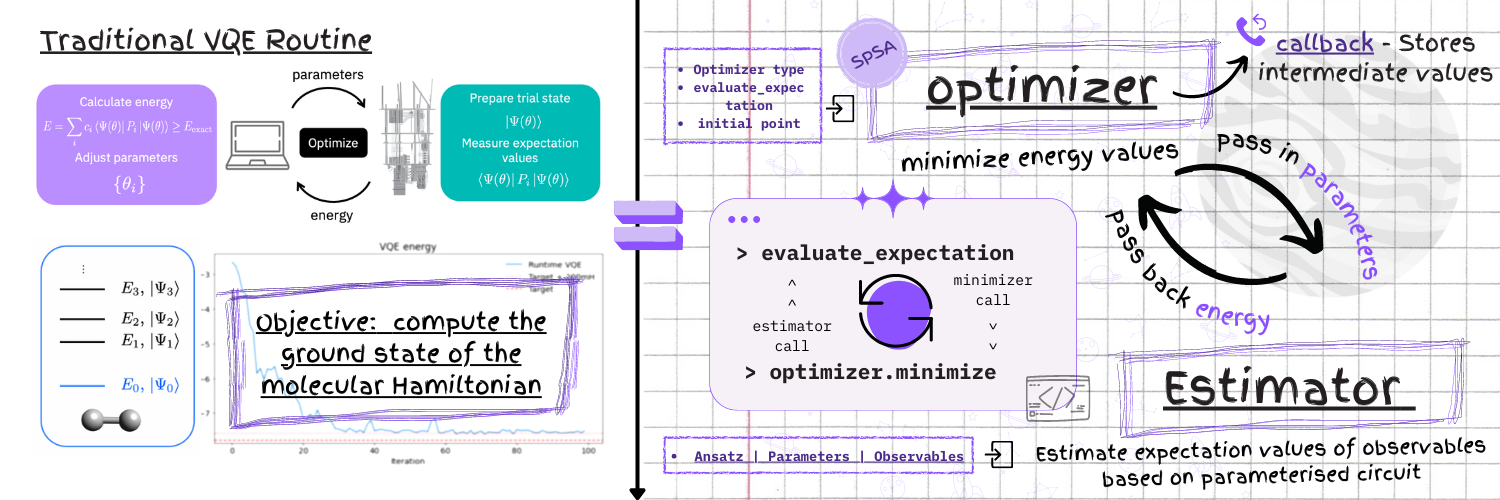

El `optimizador` que definimos se utilizará para minimizar una función escalar. Aquí deberíamos definir una función tal que devolvamos el resultado del valor esperado calculado para que se minimice. Definiremos la función `evaluate_expectation` para calcular la misma usando el `Estimator`. Esta será la función que se pasará a nuestro optimizador para resolver y generar un nuevo conjunto de parámetros a ser evaluados nuevamente.

Con el fin de visualizar el resultado y obtener una vista de los estados internos de la ejecución de optimización, también definiremos una función `callback` que agregará el valor de convergencia por ejecución y lo almacenará en una lista para visualizarla más tarde.

In [9]:
from qiskit.primitives import Estimator, BackendEstimator

## Una breve nota sobre la Primitiva Estimator

Hemos estado usando la versión Qiskit Runtime de `Estimator` hasta ahora. A los efectos de este ejercicio, utilizaremos una versión localizada del `Estimator` que reside en Qiskit Terra.

### Especificación
Hablando formalmente, la primitiva _Estimator_ es una especificación estandarizada para calcular e interpretar valores esperados para diferentes combinaciones de estados cuánticos (es decir, circuitos) y operadores. Esto significa que no existe una única clase `Estimator` para resolver esta tarea, sino una familia de ellas; cada una de las cuales realiza el mismo cálculo (interno) de una manera ligeramente diferente, mientras expone una _interfaz de programación de aplicaciones_ (application programming interface, API) común a los usuarios.

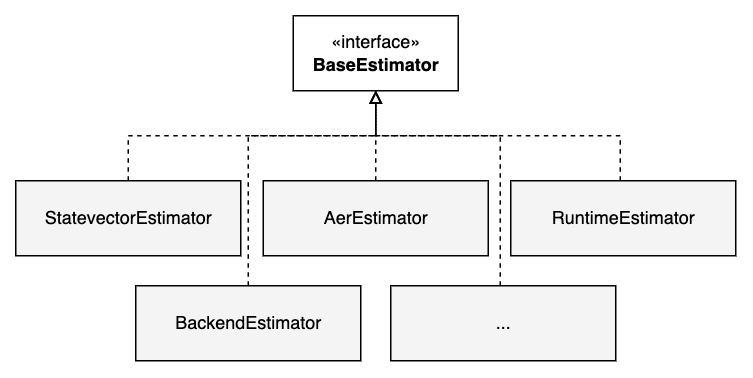

A continuación, continuaremos con la implementación nativa de Terra de Qiskit de `Estimator` y `BackendEstimator` con los simuladores nativos de Qiskit. Puedes sustituir esto con Qiskit Runtime Estimator siguiendo la misma rutina que antes si lo deseas. Aquí hay un tutorial que te ayudará **[comenzar con la clase Estimator que reside en Qiskit Terra](https://qiskit.org/documentation/apidoc/primitives.html)**

<a id="Paso 2"></a>

<div class="alert alert-block alert-success">
<b>Paso 2:</b> 
    
Completa la celda a continuación para construir nuestra rutina VQE. Define el objeto primitivo `Estimator` y define la llamada al `estimator.run` para la función `evaluate_expectation`.
Completa la llamada del optimizador usando `SPSA` con `maxiter=50` y pasa la función callback para que los valores intermedios se almacenen para el graficado. Finalmente, almacena el resultado llamando a optimizer.minimize para completar la rutina.
    
Para una calificación exitosa, usa un `ansatz UCCSD` y `maxiter=50` para tu optimizador y no modifiques ninguno de los valores semilla.  </div>

### Calcular el estado fundamental de $H_3^+$

In [ ]:
%%time
from qiskit.utils import algorithm_globals
algorithm_globals.random_seed = 1024

# Define convergence list
convergence = []

# Keep track of jobs (Do-not-modify)
job_list = []

# Initialize estimator object
estimator = Estimator()# Enter your code here

# Define evaluate_expectation function
def evaluate_expectation(x):
    x = list(x)
    
    # Define estimator run parameters
    #### escribe tu codigo abajo ####
    
    
    # Pass results back to callback function
    return np.real(results)

# Call back function
def callback(x,fx,ax,tx,nx):
    # Callback function to get a view on internal states and statistics of the optimizer for visualization
    convergence.append(evaluate_expectation(fx))

np.random.seed(10)

# Define initial point. We shall define a random point here based on the number of parameters in our ansatz
initial_point = np.random.random(ansatz.num_parameters)

#### escribe tu codigo abajo ####
# Define optimizer and pass callback function
optimizer =  # ----------- Enter your code here

# Define minimize function
result =  # ----------- Enter your code here

En la siguiente celda, interpretaremos nuestro resultado de estado propio del optimizador en el contexto de nuestra transformación de problem_reduced para la molécula que definimos anteriormente:

In [ ]:
Energy_H_t = []
for i in range(len(convergence)):
    sol = MinimumEigensolverResult()
    sol.eigenvalue = convergence[i]
    sol = problem_reduced.interpret(sol).total_energies[0]
    Energy_H_t.append(sol)
print("Computed Energy:", Energy_H_t[-1])

In [ ]:
# The following plot compares the two Estimators - with and without noise

plt.rcParams["font.size"] = 14

# plot loss and reference value
plt.figure(figsize=(12, 6), facecolor='white')
plt.plot(Energy_H_t, label="Estimator VQE H3+ IDEAL")
plt.axhline(y=real_solution_t.real, color="tab:red", ls="--", label="Target")

plt.legend(loc="best")
plt.xlabel("Iteration")
plt.ylabel("Energy [H]")
plt.title("VQE energy")
plt.show()

# En el siguiente enlace encontrarás el formulario para subir la respuesta de tu trabajo, recuerda que solo debes contestar una vez: https://forms.gle/rqG29wHeg2SnbGHRA